In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams["figure.figsize"] = (16,8)

# Preparation and EDA

In [3]:
matches = pd.read_csv('../WorldCupMatches.csv') 
cups = pd.read_csv('../WorldCups.csv') ## The attendance column in the original csv file needs to be rewritten as they were converted into 'object' class when downloaded and some zeros were missing

In [4]:
matches.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [5]:
cups.head()

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375700
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1045246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768607


In [6]:
## Drop the NAs and duplicate rows
matches = matches.dropna()
matches = matches.drop_duplicates()

In [7]:
## Sort the dataframe accourding to event date
matches['Datetime'] = pd.to_datetime(matches.Datetime)
matches = matches.sort_values(by='Datetime')

In [8]:
## Transform 'Stage' (for years with less than or equal to 16 teams, teams that did not make into quarter-final are still 
## treated as 'Group' stage(i.e. before round of 16))

def stage_trans(stage):
    if any(x in stage for x in ('Group', 'First', 'Preliminary')):
        return 'Group'
    elif any(x in stage for x in ('Third', 'third')):
        return 'Third'
    else:
        return stage


matches['Stage'] = matches['Stage'].apply(stage_trans)

## FIFA attendance trend by year

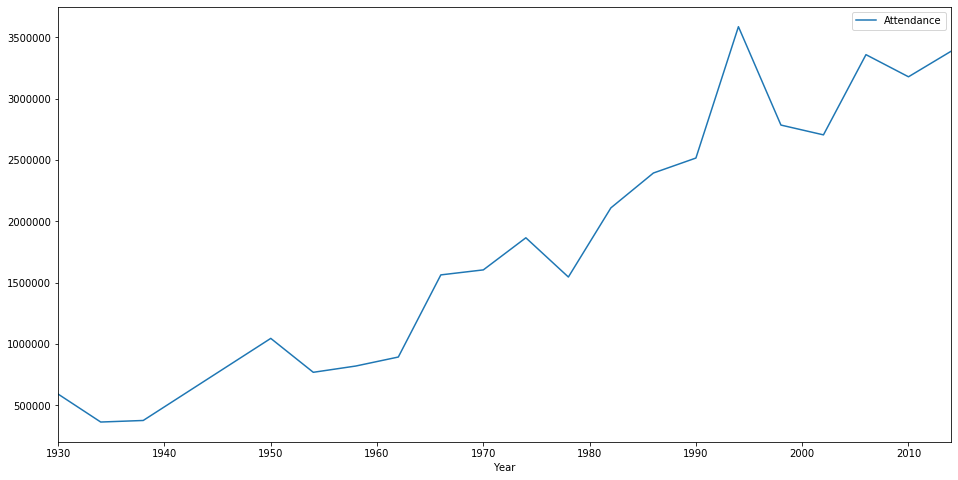

In [9]:
cups.plot(x = 'Year', y = 'Attendance')
plt.show()

## Exploring the Matches Dataset

In [10]:
## Checking whether there are teams that only present in either home or away

matches['Home Team Initials'].nunique()
matches['Away Team Initials'].nunique()
nametest = 0
for name in matches['Home Team Initials'].unique():
    if name in matches['Away Team Initials'].unique():
        nametest += 1
    else:
        nametest += 0
print(nametest)

77


In [11]:
## Calculate the result of each game

def home_win(home, away):
    if home > away:
        return 1
    else:
        return 0

def away_win(home, away):
    if away > home:
        return 1
    else:
        return 0

matches['Home Win'] = matches.apply(lambda x: home_win(x['Home Team Goals'], x['Away Team Goals']), axis=1)
matches['Away Win'] = matches.apply(lambda x: away_win(x['Home Team Goals'], x['Away Team Goals']), axis=1)
matches.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,...,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials,Home Win,Away Win
0,1930.0,1930-07-13 15:00:00,Group,Pocitos,Montevideo,France,4.0,1.0,Mexico,,...,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX,1,0
1,1930.0,1930-07-13 15:00:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,...,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL,1,0
2,1930.0,1930-07-14 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,...,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA,1,0
3,1930.0,1930-07-14 14:50:00,Group,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,...,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER,1,0
4,1930.0,1930-07-15 16:00:00,Group,Parque Central,Montevideo,Argentina,1.0,0.0,France,,...,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA,1,0


In [12]:
## Calculate the total number of games that both teams have played since the very first FIFA 
## (if this is the first time the team presents, then the value is zero)

dict = {}
def tot_game(home_name, away_name):
    if not (home_name in dict):
        dict[home_name] = 0
    else:
        dict[home_name] += 1

    if not (away_name in dict):
        dict[away_name] = 0
    else:
        dict[away_name] += 1

    return dict[home_name], dict[away_name]

matches['Home Total Game'], matches['Away Total Game'] = zip(*matches.apply(lambda x: tot_game(x['Home Team Initials'], x['Away Team Initials']), axis=1))
matches.head(10)


,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,...,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials,Home Win,Away Win,Home Total Game,Away Total Game
0,1930.0,1930-07-13 15:00:00,Group,Pocitos,Montevideo,France,4.0,1.0,Mexico,,...,CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX,1,0,0,0
1,1930.0,1930-07-13 15:00:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,...,MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL,1,0,0,0
2,1930.0,1930-07-14 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,...,VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA,1,0,0,0
3,1930.0,1930-07-14 14:50:00,Group,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,...,LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER,1,0,0,0
4,1930.0,1930-07-15 16:00:00,Group,Parque Central,Montevideo,Argentina,1.0,0.0,France,,...,SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA,1,0,0,1
5,1930.0,1930-07-16 14:45:00,Group,Parque Central,Montevideo,Chile,3.0,0.0,Mexico,,...,APHESTEGUY Martin (URU),LANGENUS Jean (BEL),201.0,1095.0,CHI,MEX,1,0,0,1
6,1930.0,1930-07-17 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,4.0,0.0,Bolivia,,...,LOMBARDI Domingo (URU),WARNKEN Alberto (CHI),201.0,1092.0,YUG,BOL,1,0,1,0
7,1930.0,1930-07-17 14:45:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Paraguay,,...,APHESTEGUY Martin (URU),TEJADA Anibal (URU),201.0,1097.0,USA,PAR,1,0,1,0
8,1930.0,1930-07-18 14:30:00,Group,Estadio Centenario,Montevideo,Uruguay,1.0,0.0,Peru,,...,BALWAY Thomas (FRA),CRISTOPHE Henry (BEL),201.0,1099.0,URU,PER,1,0,0,1
9,1930.0,1930-07-19 12:50:00,Group,Estadio Centenario,Montevideo,Chile,1.0,0.0,France,,...,LOMBARDI Domingo (URU),REGO Gilberto (BRA),201.0,1094.0,CHI,FRA,1,0,1,2


In [13]:
## Calculate number of wins for each team 
## -1 means the team has not won any game including the current one, 0 means the current game is the first game the team wins, 
## x > 1 means the team has won x games before this

dict = {}
def tot_win(home_name, away_name, home_win, away_loss):
    if not (home_name in dict):
        dict[home_name] = 0
        dict[home_name + '_w'] = 0
        if (home_win == 1):
            dict[home_name + '_w'] += 1
    else:
        dict[home_name] = dict[home_name + '_w']
        if (home_win == 1):
            dict[home_name + '_w'] += 1

    
    if not (away_name in dict):
        dict[away_name] = 0
        dict[away_name + '_w'] = 0
        if (away_win == 1):
            dict[away_name + '_w'] += 1
    else:
        dict[away_name] = dict[away_name + '_w']
        if (away_win == 1):
            dict[away_name + '_w'] += 1


    return dict[home_name], dict[away_name]

matches['Home Total Wins'], matches['Away Total Wins'] = zip(*matches.apply(lambda x: tot_win(x['Home Team Initials'], x['Away Team Initials'], x['Home Win'], x['Away Win']), axis=1))
matches.head(10)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,...,RoundID,MatchID,Home Team Initials,Away Team Initials,Home Win,Away Win,Home Total Game,Away Total Game,Home Total Wins,Away Total Wins
0,1930.0,1930-07-13 15:00:00,Group,Pocitos,Montevideo,France,4.0,1.0,Mexico,,...,201.0,1096.0,FRA,MEX,1,0,0,0,0,0
1,1930.0,1930-07-13 15:00:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,...,201.0,1090.0,USA,BEL,1,0,0,0,0,0
2,1930.0,1930-07-14 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,...,201.0,1093.0,YUG,BRA,1,0,0,0,0,0
3,1930.0,1930-07-14 14:50:00,Group,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,...,201.0,1098.0,ROU,PER,1,0,0,0,0,0
4,1930.0,1930-07-15 16:00:00,Group,Parque Central,Montevideo,Argentina,1.0,0.0,France,,...,201.0,1085.0,ARG,FRA,1,0,0,1,0,1
5,1930.0,1930-07-16 14:45:00,Group,Parque Central,Montevideo,Chile,3.0,0.0,Mexico,,...,201.0,1095.0,CHI,MEX,1,0,0,1,0,0
6,1930.0,1930-07-17 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,4.0,0.0,Bolivia,,...,201.0,1092.0,YUG,BOL,1,0,1,0,1,0
7,1930.0,1930-07-17 14:45:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Paraguay,,...,201.0,1097.0,USA,PAR,1,0,1,0,1,0
8,1930.0,1930-07-18 14:30:00,Group,Estadio Centenario,Montevideo,Uruguay,1.0,0.0,Peru,,...,201.0,1099.0,URU,PER,1,0,0,1,0,0
9,1930.0,1930-07-19 12:50:00,Group,Estadio Centenario,Montevideo,Chile,1.0,0.0,France,,...,201.0,1094.0,CHI,FRA,1,0,1,2,1,1


In [14]:
## Calculate Win-rate

dict = {}
def win_rate(home_wins, away_wins, home_games, away_games):
    if home_games == 0:
        dict["Home"] = 0
    else:
        dict["Home"] = home_wins / home_games

    if away_games == 0:
        dict["Away"] = 0
    else:
        dict["Away"] = away_wins / away_games

    return dict['Home'], dict['Away']

matches['Home Win-rate'], matches['Away Win-rate'] = zip(*matches.apply(lambda x: win_rate(x['Home Total Wins'], x['Away Total Wins'], x['Home Total Game'], x['Away Total Game']), axis=1))
matches.head(10)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,...,Home Team Initials,Away Team Initials,Home Win,Away Win,Home Total Game,Away Total Game,Home Total Wins,Away Total Wins,Home Win-rate,Away Win-rate
0,1930.0,1930-07-13 15:00:00,Group,Pocitos,Montevideo,France,4.0,1.0,Mexico,,...,FRA,MEX,1,0,0,0,0,0,0.0,0.0
1,1930.0,1930-07-13 15:00:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,...,USA,BEL,1,0,0,0,0,0,0.0,0.0
2,1930.0,1930-07-14 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,...,YUG,BRA,1,0,0,0,0,0,0.0,0.0
3,1930.0,1930-07-14 14:50:00,Group,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,...,ROU,PER,1,0,0,0,0,0,0.0,0.0
4,1930.0,1930-07-15 16:00:00,Group,Parque Central,Montevideo,Argentina,1.0,0.0,France,,...,ARG,FRA,1,0,0,1,0,1,0.0,1.0
5,1930.0,1930-07-16 14:45:00,Group,Parque Central,Montevideo,Chile,3.0,0.0,Mexico,,...,CHI,MEX,1,0,0,1,0,0,0.0,0.0
6,1930.0,1930-07-17 12:45:00,Group,Parque Central,Montevideo,Yugoslavia,4.0,0.0,Bolivia,,...,YUG,BOL,1,0,1,0,1,0,1.0,0.0
7,1930.0,1930-07-17 14:45:00,Group,Parque Central,Montevideo,USA,3.0,0.0,Paraguay,,...,USA,PAR,1,0,1,0,1,0,1.0,0.0
8,1930.0,1930-07-18 14:30:00,Group,Estadio Centenario,Montevideo,Uruguay,1.0,0.0,Peru,,...,URU,PER,1,0,0,1,0,0,0.0,0.0
9,1930.0,1930-07-19 12:50:00,Group,Estadio Centenario,Montevideo,Chile,1.0,0.0,France,,...,CHI,FRA,1,0,1,2,1,1,1.0,0.5


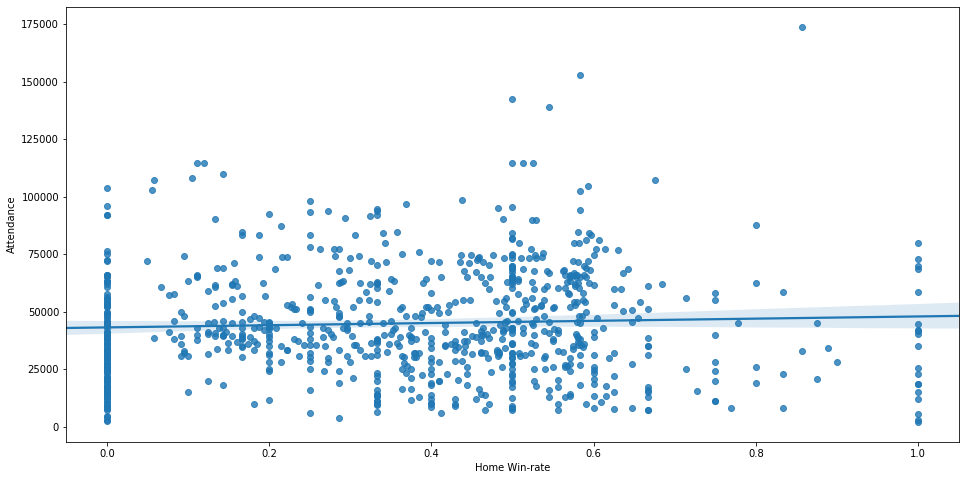

In [15]:
## Relationship between attendance and team winrates

sns.regplot(x='Home Win-rate', y='Attendance', data=matches)

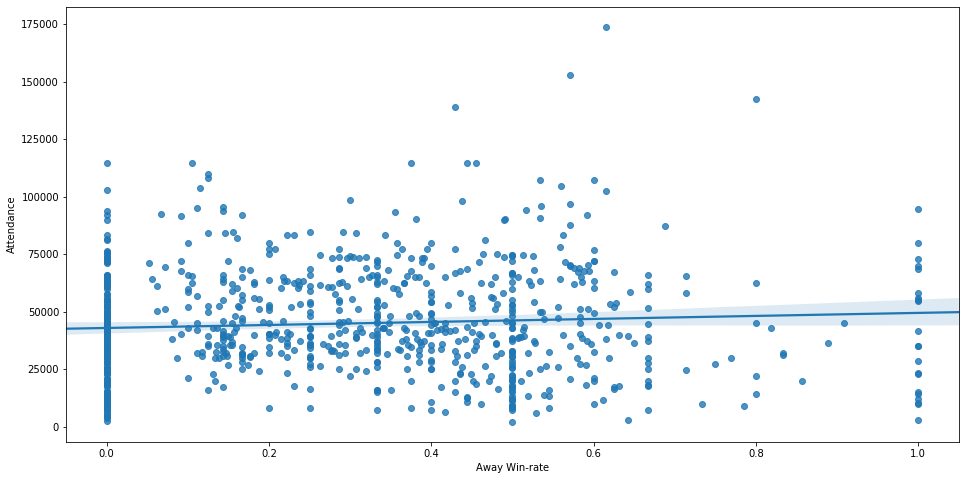

In [16]:
sns.regplot(x='Away Win-rate', y='Attendance', data=matches)

In [17]:
## Check association between Stage and Attendance

mod_stage = ols('Attendance ~ Stage', data=matches).fit()
aov_table = sm.stats.anova_lm(mod_stage, typ=2)
print (aov_table)

                sum_sq     df          F        PR(>F)
Stage     3.379791e+10    5.0  13.068799  2.897984e-12
Residual  4.287841e+11  829.0        NaN           NaN


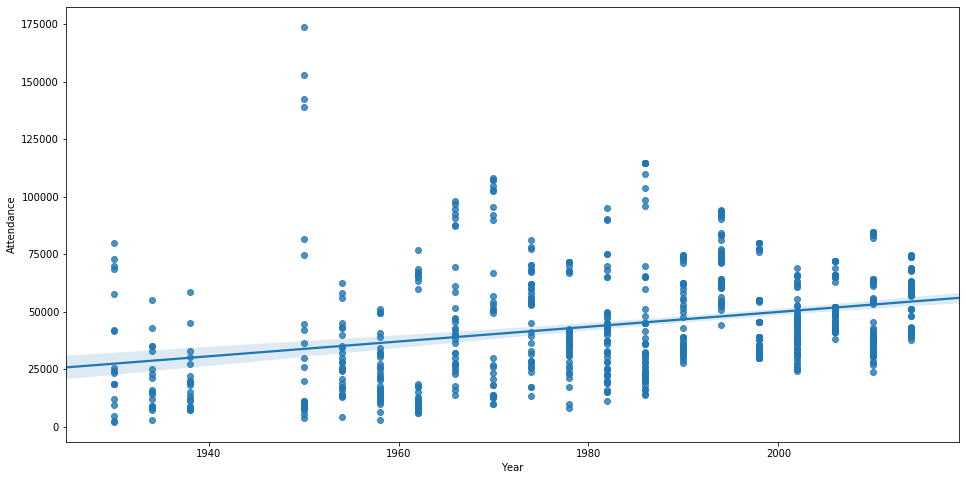

In [18]:
sns.regplot(x='Year', y='Attendance', data=matches)

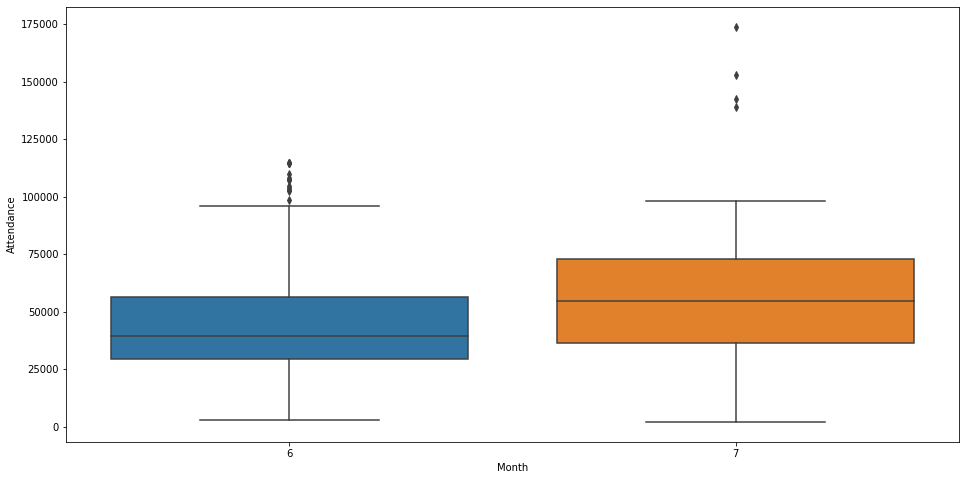

In [19]:
## Games that took place in May were all in pretty late date in that month (i.e after May 27th). 
## Therefore, May is treated as June for simplicity

matches['Month'] = matches['Datetime'].dt.month
matches['Month'] = matches['Month'].apply(lambda x: 6 if x == 5 else x)
sns.boxplot(x='Month', y='Attendance', data=matches)

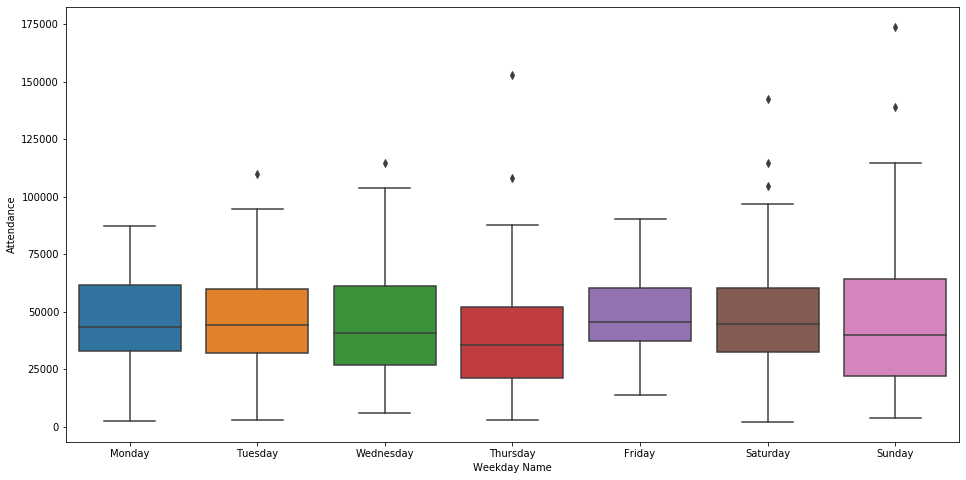

In [20]:
## Check Month vs Attendance

matches['Weekday Name'] = matches['Datetime'].dt.weekday_name
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='Weekday Name', y='Attendance', data=matches, order=order)

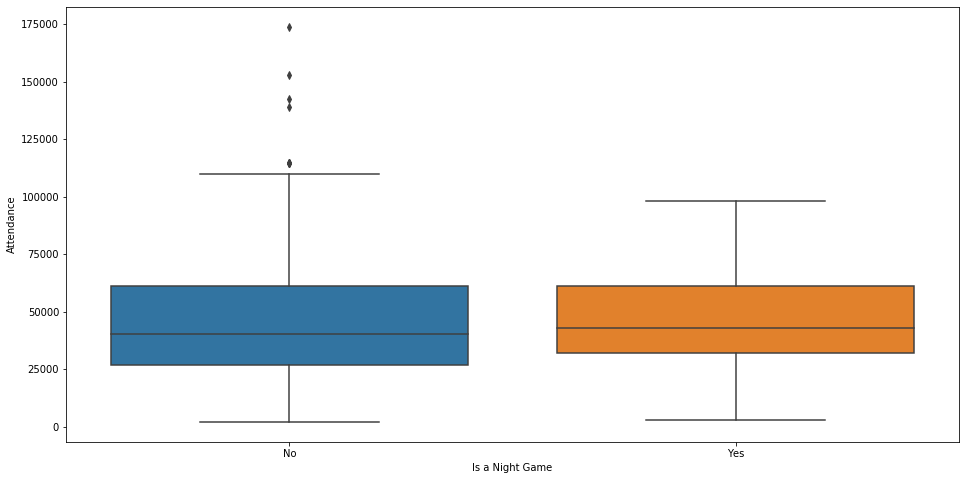

In [21]:
## Check whether the game being a night game (after 18:00) has relationship with attendance

matches['Hour'] = matches['Datetime'].dt.hour

def night(hour):
    if hour < 18:
        return('No')
    else:
        return('Yes')
matches['Is a Night Game'] = matches.apply(lambda x: night(x['Hour']), axis=1)

sns.boxplot(x='Is a Night Game', y='Attendance', data=matches)

# Model Building

In [22]:
## Drop unnecessary attributes

matches.drop(["Datetime",
         "Stadium",
         "City",
         "Home Team Goals",
         "Away Team Goals",
         "Win conditions",
         "Half-time Home Goals",
         "Half-time Away Goals",
         "Referee",
         "Assistant 1",
         "Assistant 2",
         "RoundID",
         "MatchID",
         "Home Team Initials",
         "Away Team Initials",
         "Weekday Name",
         "Hour",
         "Is a Night Game"
    ],
        axis = 1, inplace = True)
matches.head()

,Year,Stage,Home Team Name,Away Team Name,Attendance,Home Win,Away Win,Home Total Game,Away Total Game,Home Total Wins,Away Total Wins,Home Win-rate,Away Win-rate,Month
0,1930.0,Group,France,Mexico,4444.0,1,0,0,0,0,0,0.0,0.0,7
1,1930.0,Group,USA,Belgium,18346.0,1,0,0,0,0,0,0.0,0.0,7
2,1930.0,Group,Yugoslavia,Brazil,24059.0,1,0,0,0,0,0,0.0,0.0,7
3,1930.0,Group,Romania,Peru,2549.0,1,0,0,0,0,0,0.0,0.0,7
4,1930.0,Group,Argentina,France,23409.0,1,0,0,1,0,1,0.0,1.0,7


In [23]:
## Start building model

matches2 = matches.drop([
         "Home Win",
         "Away Win",
         "Home Total Game",
         "Away Total Game",
         "Home Total Wins",
         "Away Total Wins",
         "Home Team Name",
         "Away Team Name"
    ],
        axis = 1, inplace = False)
matches2 = matches2.reset_index(drop=True)

In [24]:
## Encode the categorical variables

lb = LabelBinarizer()
Stage_lb = lb.fit_transform(matches2.Stage.values)
Month_lb = lb.fit_transform(matches2.Month.values)

In [25]:
df_lb = pd.DataFrame(Stage_lb, columns = ['Final', 'Group', 'Quarter-finals', 'Round of 16', 'Semi Final', 'Third'])
matches2 = pd.concat([matches2, df_lb], axis=1)
df_lb = pd.DataFrame(Month_lb, columns = ['July'])
matches2 = pd.concat([matches2, df_lb], axis=1)

In [26]:
matches2.head()

,Year,Stage,Attendance,Home Win-rate,Away Win-rate,Month,Final,Group,Quarter-finals,Round of 16,Semi Final,Third,July
0,1930.0,Group,4444.0,0.0,0.0,7,0,1,0,0,0,0,1
1,1930.0,Group,18346.0,0.0,0.0,7,0,1,0,0,0,0,1
2,1930.0,Group,24059.0,0.0,0.0,7,0,1,0,0,0,0,1
3,1930.0,Group,2549.0,0.0,0.0,7,0,1,0,0,0,0,1
4,1930.0,Group,23409.0,0.0,1.0,7,0,1,0,0,0,0,1


In [27]:
X = matches2.drop(['Stage','Month','Attendance'], axis = 1)
y = matches2.Attendance
X.insert(loc=0, column='const', value=1.0)

In [28]:
## Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [29]:
## OLS regression

OLS_model = OLS(y_train, X_train).fit()
OLS_pred = OLS_model.predict(X_test)
OLS_model_score = r2_score(y_test, OLS_pred)

print ("R^2:", OLS_model_score)

R^2: 0.19833589281834418


In [30]:
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     18.84
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.14e-27
Time:                        22:16:26   Log-Likelihood:                -6626.7
No. Observations:                 584   AIC:                         1.327e+04
Df Residuals:                     574   BIC:                         1.332e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.061e+05   7.67e+04     -9.201      0.000   -8.57e+05   -5.55e+05
Year             437.6045     44.576      9.817      0.000     350.052     525.157
Home Win-rate   9816.6325   4023.780      2.440      0.015    1913.505    1.77e+04
Away Win-rate   7874.9015   3793.804      2.076      0.038     423.470    1.53e+04
Final          -9.608e+04   1.39e+04     -6.920      0.000   -1.23e+05   -6.88e+04
Group          -1.271e+05   1.26e+04    -10.094      0.000   -1.52e+05   -1.02e+05
Quarter-finals -1.274e+05   1.31e+04     -9.702      0.000   -1.53e+05   -1.02e+05
Round of 16    -1.242e+05   1.36e+04     -9.154      0.000   -1.51e+05   -9.76e+04
Semi Final     -1.114e+05   1.34e+04     -8.319      0.000   -1.38e+05   -8.51e+04
Third          -1.198e+05   1.37e+04     -8.742      0.000   -1.47e+05   -9.29e+04
July            1.035e+04   2573.654      4.021      0.000    5292.624    1.54e+04
==============================================================================
Omnibus:                      181.531   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.454
Skew:                           1.504   Prob(JB):                    3.24e-117
Kurtosis:                       6.605   Cond. No.                     1.28e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
## Check multicollinearity

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

    VIF Factor        features
0     0.000000           const
1     1.318959            Year
2     1.270233   Home Win-rate
3     1.227386   Away Win-rate
4          inf           Final
5          inf           Group
6          inf  Quarter-finals
7          inf     Round of 16
8          inf      Semi Final
9          inf           Third
10    1.200616            July


In [32]:
## RandomForest

X = matches2.drop(['Stage','Month','Attendance'], axis = 1)
y = matches2.Attendance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

def evaluate(model):        
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    model_score = r2_score(y_test, pred)
        
    print ("R^2 score:", model_score)
    
    df = pd.DataFrame(columns=['attendance', 'predictions', 'residuals'])
    df.attendance = y
    df.predictions = model.predict(X)
    df.residuals = df.attendance - df.predictions
    df.plot(x='predictions', y='residuals', kind='scatter')
    plt.show()

In [33]:
rf = RandomForestRegressor(n_estimators=300)

R^2 score: 0.3128852695378048


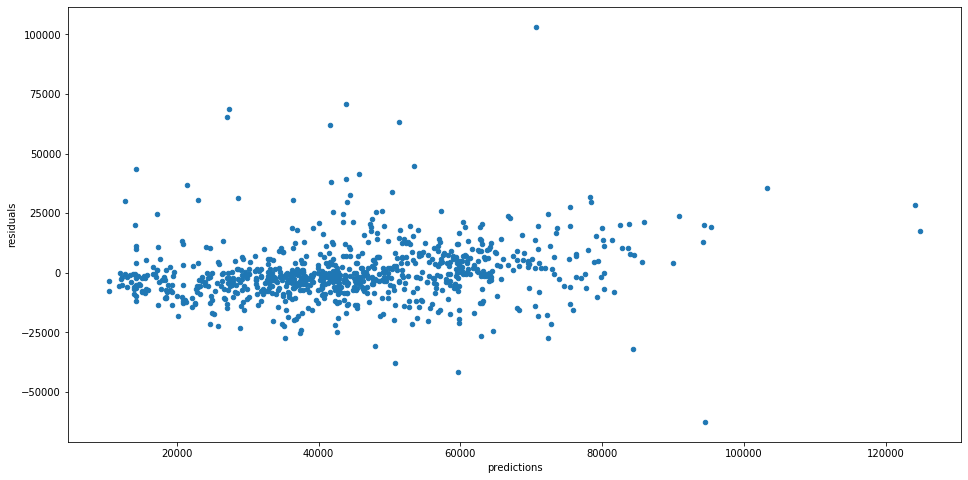

In [34]:
evaluate(rf)

In [35]:
## Check importance of each variable

def feat_imp(model):
    feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['importance']
                                      ).sort_values('importance', ascending=False)
    return (feature_importances)
    
importance = feat_imp(rf)
print(importance)

                importance
Year              0.320463
Home Win-rate     0.274778
Away Win-rate     0.232719
July              0.062089
Group             0.040196
Final             0.032429
Semi Final        0.015932
Third             0.007856
Quarter-finals    0.007216
Round of 16       0.006322


<BarContainer object of 10 artists>

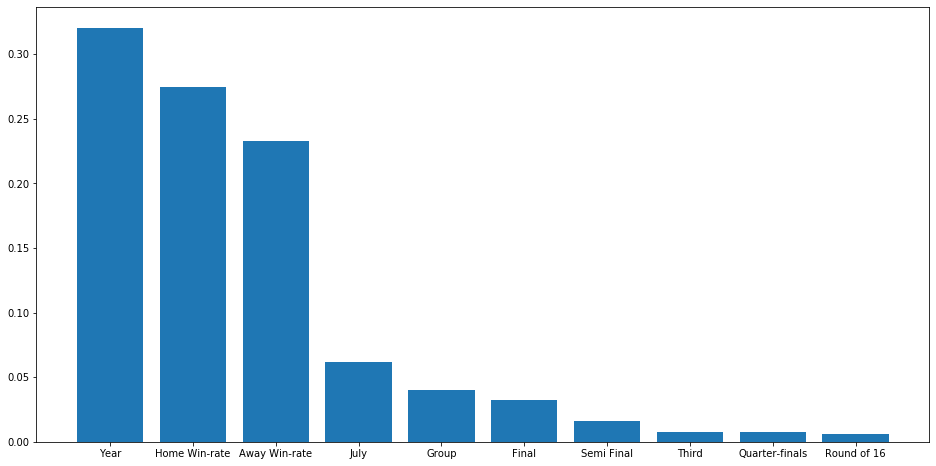

In [36]:
plt.bar(importance.index, importance.importance)